In [ ]:
!pip install pydub

In [ ]:
import wave
from pydub import AudioSegment

In [ ]:
with wave.open('/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/raw_data/backgrounds/back3-[AudioTrimmer.com] (1).wav', 'rb') as wav_file:
    # Get the number of frames and the frame rate
    num_frames = wav_file.getnframes()
    frame_rate = wav_file.getframerate()
print(num_frames)
print(frame_rate)

96000
48000


In [1]:
import numpy as np
!pip install pydub
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
# copy this file to /usr/local/lib/python3.10/dist-packages/td_utils_c.py then import it
!cp "/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/td_utils_c.py" "/usr/local/lib/python3.10/dist-packages/td_utils_c.py"
from td_utils_c import *

In [2]:
Tx = 1198
n_freq = 101
Ty = 296

In [3]:
activates, negatives, backgrounds = load_raw_audio()
for f in backgrounds:
  print("background len: " + str(len(f)))   # Should be 2,000, since it is a 2 secs clip
print("activate[0] len: " + str(len(activates[0]))) 
print("activate[1] len: " + str(len(activates[1])))

yarb
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
background len: 2000
activate[0] len: 686
activate[1] len: 1056


In [4]:
def get_random_time_segment(segment_ms):
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background
    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)

def is_overlapping(segment_time, previous_segments):

    segment_start, segment_end = segment_time
    overlap = False
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    return overlap

def insert_audio_clip(background, audio_clip, previous_segments):

    segment_ms = len(audio_clip)

    segment_time = get_random_time_segment(segment_ms)

    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)
    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position = segment_time[0])
    return new_background, segment_time

def insert_ones(y, segment_end_ms):

    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    return y

def create_training_example(backgrounds, activates, negatives):

    # Set the random seed
    np.random.seed(18)

    y = np.zeros((1, Ty))

    previous_segments = []

    random_background = backgrounds[np.random.randint(0,len(backgrounds))]
    random_background = random_background - 20

    number_of_activates = np.random.randint(0, 2)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]

    for random_activate in random_activates:
        random_background, segment_time = insert_audio_clip(random_background, random_activate, previous_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end_ms=segment_end)

    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    for random_negative in random_negatives:
        random_background, _ = insert_audio_clip(random_background, random_negative, previous_segments)

    random_background = match_target_amplitude(random_background, -20.0)
    file_handle = random_background.export("train" + ".wav", format="wav")
    x = graph_spectrogram("train.wav")

    return x, y

def make_training_set(num_samples):

    x_store = []
    y_store = []
    n = 0
    for i in range(num_samples):
        x_sample, y_sample = create_training_example(backgrounds,activates,negatives)
        x_store.append(x_sample)
        y_store.append(y_sample)
        n += 1
        if(n%50 == 0):
            print(f'{n} out of {num_samples}')
    x_total = np.concatenate(x_store,axis=0)
    y_total = np.concatenate(y_store,axis=0)
    np.save('drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/x_train_small.npy',x_total)
    np.save('drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/y_train_small.npy',y_total)
    print(f'u have saved a npy with {n} samples')

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.94882096e+02, 3.93285215e+04, 2.61955580e+04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.58394020e+04, 6.18832483e+04, 6.32078529e+04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.72986621e+03, 1.50888161e+04, 8.41688745e+03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78534704e-01, 2.29785146e-01, 1.38940372e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.90134537e-01, 1.83780745e+00, 7.77497766e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.95101957e-01, 1.62306553e+00, 1.09614239e+00]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0

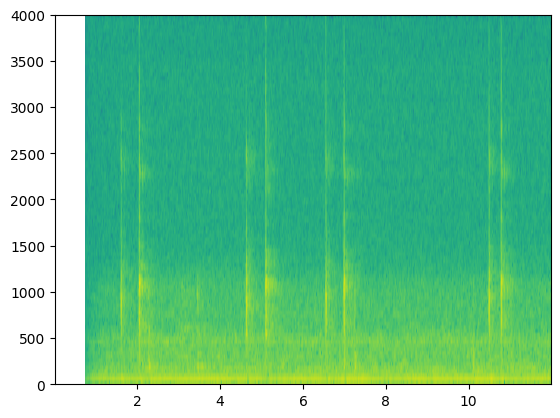

In [8]:
create_training_example(backgrounds, activates, negatives)

In [ ]:
make_training_set(3000)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


50 out of 3000
100 out of 3000
150 out of 3000
200 out of 3000
250 out of 3000
300 out of 3000
350 out of 3000
400 out of 3000
450 out of 3000
500 out of 3000
550 out of 3000
600 out of 3000
650 out of 3000
700 out of 3000
750 out of 3000
800 out of 3000
850 out of 3000
900 out of 3000
950 out of 3000
1000 out of 3000
1050 out of 3000
1100 out of 3000
1150 out of 3000
1200 out of 3000
1250 out of 3000
1300 out of 3000
1350 out of 3000
1400 out of 3000
1450 out of 3000
1500 out of 3000
1550 out of 3000
1600 out of 3000
1650 out of 3000
1700 out of 3000
1750 out of 3000
1800 out of 3000
1850 out of 3000
1900 out of 3000
1950 out of 3000
2000 out of 3000
2050 out of 3000
2100 out of 3000
2150 out of 3000
2200 out of 3000
2250 out of 3000
2300 out of 3000
2350 out of 3000
2400 out of 3000
2450 out of 3000
2500 out of 3000
2550 out of 3000
2600 out of 3000
2650 out of 3000
2700 out of 3000
2750 out of 3000
2800 out of 3000
2850 out of 3000
2900 out of 3000
2950 out of 3000
3000 out of 3000


In [ ]:
X = np.load("/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/x_train_small.npy")
Y = np.load("/content/drive/MyDrive/Colab Notebooks/my-Trigger-Word-Detection/y_train_small.npy")

NameError: ignored

In [ ]:
Y.shape

(10, 296)